<a href="https://colab.research.google.com/github/MrEplenier/fraud-detection/blob/master/detection_fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports des modules et de la base de données**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import seaborn as sns
import time

import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
# Base de données importée depuis mon Google Drive
data = pd.read_csv('/content/drive/My Drive/Fac/Mémoire/PS_20174392719_1491204439457_log.csv')

## **Description de la base de données**


https://www.kaggle.com/ntnu-testimon/paysim1

<br>

* **`step`** : Unité de temps en heure (simulation sur 30 jours)
* **`type`** : Type de transaction
* **`amount`** : Montant de la transaction

<br>

* **`nameOrig`** : Emetteur
* **`oldbalanceOrg`** : Solde de l'émetteur avant la transaction
* **`newbalanceOrg`** : Solde de l'émetteur après la transaction

<br>

* **`nameDest`** : Receveur
* **`oldbalanceDest`** : Solde du receveur avant la transaction
* **`newbalanceDest`** : Solde du receveur après la transaction

<br>

* **`isFraud`** : Fraude détectée (1) ou non-détectée (0)
* **`isFlaggedFraud`** : Virements de plus de 200,000

In [ ]:
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [ ]:
a = len(data[data["isFraud"] == 0])
b = len(data[data["isFraud"] == 1])
total = len(data)

print("Nombre d'entrées non-frauduleuses : {:.2%}".format(a/total))
print("Nombre d'entrées frauduleuses : {:.2%}".format(b/total))

Nombre d'entrées non-frauduleuses : 99.87%
Nombre d'entrées frauduleuses : 0.13%


## **Transformation de la base de données**

#### **Suppression de variables inutiles**

La variable "isFlaggedFraud" est incomplète car comme nous pouvons le voir ci-dessous, 5455 entrées de notre dataset ont un montant dépassant 200,000 et ont été détectées comme frauduleuse ("isFraud" = 1) mais n'ont pas été labéllisées à "1" par la variable "isFlaggedFraud".

Seulement 16 entrées de notre dataset ont été labellisées à "1" pour la variable "isFlaggedFraud". Cela représente 0.0013%, ce qui est négligeable.

Nous décidons par conséquent de ne pas considérer cette variable de notre dataset car elle est inutile.


In [ ]:
a = data[data["isFlaggedFraud"] == 1]
print("Nombre des virements frauduleux dépassant les 200,000 dont \"isFlaggedFraud\" = 1 : {}".format(len(a)))

Nombre des virements frauduleux dépassant les 200,000 dont "isFlaggedFraud" = 1 : 16


In [ ]:
a = data[(data["amount"] >= 200000) \
     & (data["isFraud"] == 1) \
     & (data["isFlaggedFraud"] == 0)]

print("Nombre des virements frauduleux dépassant les 200,000 et dont isFlaggedFraud = 0 : {}".format(len(a)))

Nombre des virements frauduleux dépassant les 200,000 et dont isFlaggedFraud = 0 : 5455


In [ ]:
data = data.drop(columns = ["isFlaggedFraud"])

La variable "step" n'est pas non plus à considérer pour l'entraînement de notre futur modèle au vu de l'information qu'elle donne.

In [ ]:
data = data.drop(columns = ["step"])

In [ ]:
data = data.drop(columns = ["nameOrig", "nameDest"])

#### **One-Hot Encoding sur la variable "type"**


Etant donnée que la variable "type" est une variable catagorielles, nous devons appliquer la méthode du One-Hot Encoding qui consiste en deux étapes :

* Splitter la variable en différentes sous-variables (chaque catégorie)
* Pour chaque entrée, attribuer 1 si la catégorie est présente sinon 0

In [ ]:
one_hot_type = pd.get_dummies(data["type"], prefix="type")
one_hot_type

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0
...,...,...,...,...,...
6362615,0,1,0,0,0
6362616,0,0,0,0,1
6362617,0,1,0,0,0
6362618,0,0,0,0,1


In [ ]:
data = pd.concat([one_hot_type, data], axis = 1)
data = data.drop(columns = ["type"])
data

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0,0,0,1,0,9839.64,170136.00,160296.36,0.00,0.00,0
1,0,0,0,1,0,1864.28,21249.00,19384.72,0.00,0.00,0
2,0,0,0,0,1,181.00,181.00,0.00,0.00,0.00,1
3,0,1,0,0,0,181.00,181.00,0.00,21182.00,0.00,1
4,0,0,0,1,0,11668.14,41554.00,29885.86,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,0,1,0,0,0,339682.13,339682.13,0.00,0.00,339682.13,1
6362616,0,0,0,0,1,6311409.28,6311409.28,0.00,0.00,0.00,1
6362617,0,1,0,0,0,6311409.28,6311409.28,0.00,68488.84,6379898.11,1
6362618,0,0,0,0,1,850002.52,850002.52,0.00,0.00,0.00,1


#### **Normalisation des variables**

In [ ]:
data_temp = data.drop(columns=["isFraud"])

In [ ]:
data_temp = (data_temp-data_temp.min()) / (data_temp.max()-data_temp.min())

In [ ]:
data = pd.concat([data_temp, data["isFraud"]], axis = 1)
data

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0.0,0.0,0.0,1.0,0.0,0.000106,0.002855,0.003233,0.000000,0.000000,0
1,0.0,0.0,0.0,1.0,0.0,0.000020,0.000357,0.000391,0.000000,0.000000,0
2,0.0,0.0,0.0,0.0,1.0,0.000002,0.000003,0.000000,0.000000,0.000000,1
3,0.0,1.0,0.0,0.0,0.0,0.000002,0.000003,0.000000,0.000059,0.000000,1
4,0.0,0.0,0.0,1.0,0.0,0.000126,0.000697,0.000603,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,0.0,1.0,0.0,0.0,0.0,0.003674,0.005701,0.000000,0.000000,0.000954,1
6362616,0.0,0.0,0.0,0.0,1.0,0.068272,0.105923,0.000000,0.000000,0.000000,1
6362617,0.0,1.0,0.0,0.0,0.0,0.068272,0.105923,0.000000,0.000192,0.017912,1
6362618,0.0,0.0,0.0,0.0,1.0,0.009195,0.014265,0.000000,0.000000,0.000000,1


## **Séparation fraude/non-fraude**

In [ ]:
data_fraude = data[data["isFraud"] == 1]
data_non_fraude = data[data["isFraud"] == 0]

## **Création des bases de train/test**

In [ ]:
class FraudDataset(Dataset):

  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.inputs = torch.tensor(dataframe.drop(columns = ["isFraud"]).values)
    self.transform = transform

  def __getitem__(self, index):
    sample = self.inputs[index]
    return sample

  def __len__(self):
    return len(self.dataframe)

In [ ]:
dataset_fraude = FraudDataset(dataframe = data_fraude)
dataset_non_fraude = FraudDataset(dataframe = data_non_fraude)

print(len(dataset_fraude))
print(len(dataset_non_fraude))

8213
6354407


Etant donné que nous sommes face à un problème de détection d'anomalies, nous devons entraîner notre modèle uniquement sur les cas non frauduleux.
Nous allons donc séparer uniquement la base de données des cas non frauduleux en train/test.

In [ ]:
split_coeff = 0.99
train_part = np.floor(split_coeff*len(dataset_non_fraude))
test_part = len(dataset_non_fraude)-train_part
non_fraude_train, non_fraude_test = random_split(dataset_non_fraude, [int(train_part), int(test_part)])

In [ ]:
print("Nombre de données d'entraînement : {:,}".format(len(non_fraude_train)))
print("Nombre de données de test : {:,}".format(len(non_fraude_test)))

Nombre de données d'entraînement : 6,290,862
Nombre de données de test : 63,545


## **Modèle : Autoencoder**

Comme nous l'avons expliquer ci-dessus, nous allons utiliser la dataset des cas non frauduleux (cas usuels) pour entraîner et tester notre modèle.
Une fois que notre modèle sera assez robuste sur les cas usuels, nous l'utiliserons sur la dataset des cas frauduleux pour tester sa performance à détecter ces anomalies. 

*Le modèle choisi est un autoencoder...*



#### **Architecture du modèle**

In [ ]:
class AeNet(nn.Module):
  
  def __init__(self):
    super(AeNet, self).__init__()

    self.enc1 = nn.Linear(10,8)
    self.enc2 = nn.Linear(8,6)
    self.enc3 = nn.Linear(6,4)
    self.enc4 = nn.Linear(4,2)

    self.dec1 = nn.Linear(2,4)
    self.dec2 = nn.Linear(4,6)
    self.dec3 = nn.Linear(6,8)
    self.dec4 = nn.Linear(8,10)

  def forward(self, x):

    x = F.relu(self.enc1(x))
    x = torch.tanh(self.enc2(x))
    x = F.relu(self.enc3(x))
    x = torch.tanh(self.enc4(x))

    x = F.relu(self.dec1(x))
    x = torch.tanh(self.dec2(x))
    x = F.relu(self.dec3(x))
    x = torch.tanh(self.dec4(x))

    return x

model = AeNet().double()

In [ ]:
print(model)

AeNet(
  (enc1): Linear(in_features=10, out_features=8, bias=True)
  (enc2): Linear(in_features=8, out_features=6, bias=True)
  (enc3): Linear(in_features=6, out_features=4, bias=True)
  (enc4): Linear(in_features=4, out_features=2, bias=True)
  (dec1): Linear(in_features=2, out_features=4, bias=True)
  (dec2): Linear(in_features=4, out_features=6, bias=True)
  (dec3): Linear(in_features=6, out_features=8, bias=True)
  (dec4): Linear(in_features=8, out_features=10, bias=True)
)


In [ ]:
torch.save(model, "/content/AE_fraud_model.pt")

#### **Entraînement du modèle**

In [ ]:
nb_epochs = 12
batch_size = 1024
learning_rate = 0.001

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

Nous allons créer ce que l'on appelle des DataLoader, c'est un objet PyTorch qui permet découper un dataset en plusieurs petits paquets (mini-batchs). Cela permettra à notre modèle d'apprendre plus rapidement. 

In [ ]:
trainloader = DataLoader(non_fraude_train, batch_size = batch_size, shuffle = True, num_workers = 0)
testloader = DataLoader(non_fraude_test, batch_size = batch_size, shuffle = True, num_workers = 0)

------- epoch : 1/12 ------- 100%
loss : 0.7469%
learning rate : 0.001
time : 55.48



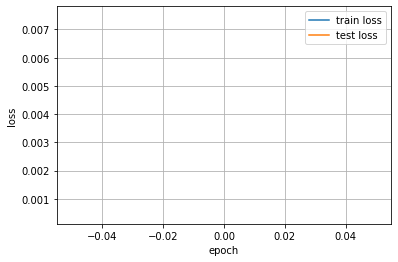



------- epoch : 2/12 ------- 100%
loss : 0.0254%
learning rate : 0.001
time : 56.29



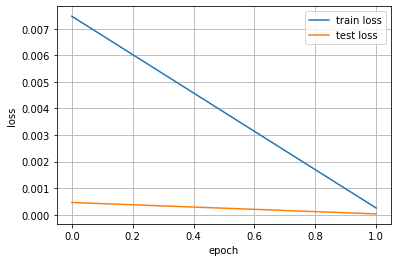



------- epoch : 3/12 ------- 100%
loss : 0.0026%
learning rate : 0.001
time : 57.6



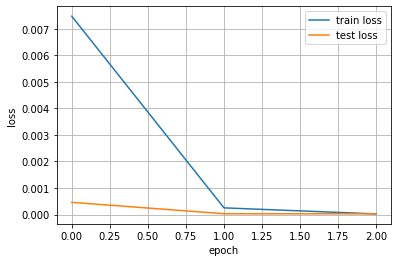



------- epoch : 4/12 ------- 100%
loss : 0.0025%
learning rate : 0.001
time : 55.97



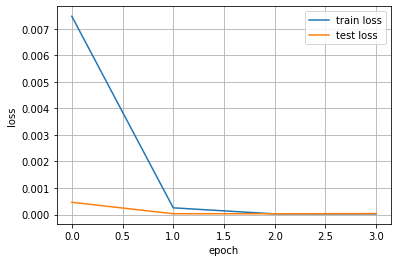



------- epoch : 5/12 ------- 100%
loss : 0.0025%
learning rate : 0.001
time : 55.58



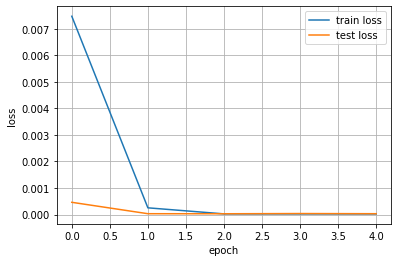



------- epoch : 6/12 ------- 100%
loss : 0.0025%
learning rate : 0.001
time : 56.07



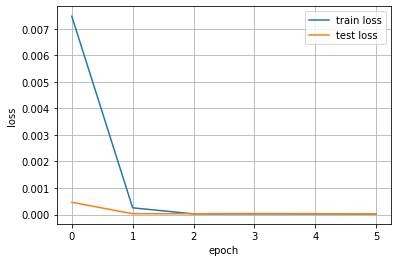



------- epoch : 7/12 ------- 100%
loss : 0.0024%
learning rate : 0.001
time : 56.09



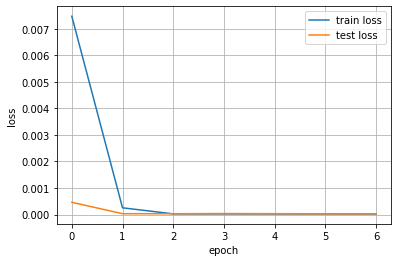



------- epoch : 8/12 ------- 100%
loss : 0.0024%
learning rate : 0.001
time : 56.17



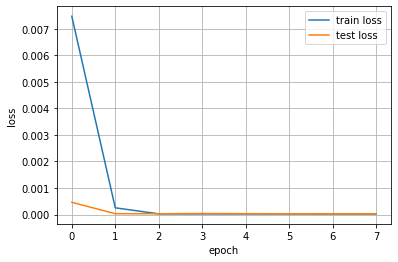



------- epoch : 9/12 ------- 100%
loss : 0.0025%
learning rate : 0.001
time : 55.98



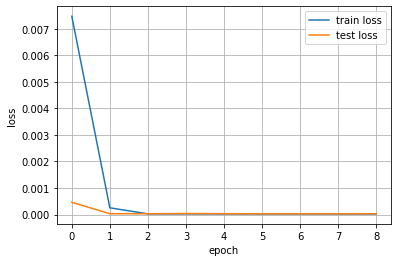



------- epoch : 10/12 ------- 100%
loss : 0.0024%
learning rate : 0.001
time : 55.65



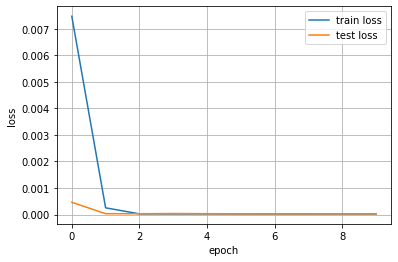



------- epoch : 11/12 ------- 100%
loss : 0.0024%
learning rate : 0.001
time : 55.37



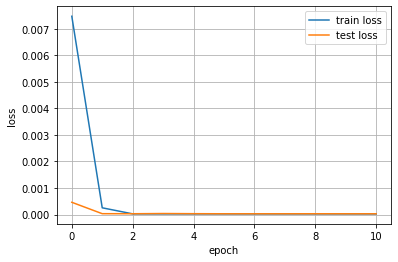



------- epoch : 12/12 ------- 100%
loss : 0.0024%
learning rate : 0.001
time : 55.57



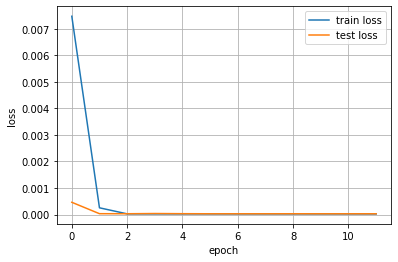

In [ ]:
train_loss_hist = []
test_loss_hist = []

for epoch in range(nb_epochs):

  train_loss = 0
  test_loss = 0
  start = time.time()

  for i, inputs in enumerate(trainloader, 0):

    # Progression
    print(f"\r------- epoch : {epoch+1}/{nb_epochs} ------- {i/len(trainloader):.0%}", end = "")

    # Gradients are initialize to zero on every step 
    optimizer.zero_grad()

    # forward propagation
    outputs = model.forward(inputs)

    # Loss computation (MSE)
    loss = criterion(outputs, inputs)

    # Backward propagation
    loss.backward()

    # Weigths update
    optimizer.step()

    train_loss += loss.item()

  # Test loss
  with torch.no_grad():
    for i, inputs in enumerate(testloader, 0):
      outputs = model.forward(inputs)
      loss = criterion(outputs, inputs)
      test_loss += loss.item()

  train_loss = train_loss/len(trainloader)
  test_loss = test_loss/len(testloader)

  train_loss_hist.append(train_loss)
  test_loss_hist.append(test_loss)

  stop = time.time()

  print(f"\nloss : {train_loss:.4%}")
  print(f"learning rate : {learning_rate:.4}")
  print(f"time : {stop-start:.4}\n")
  plt.plot(range(len(train_loss_hist)), train_loss_hist, label = "train loss")
  plt.plot(range(len(train_loss_hist)), test_loss_hist, label = "test loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.grid(True)
  plt.show()
  print("\n")

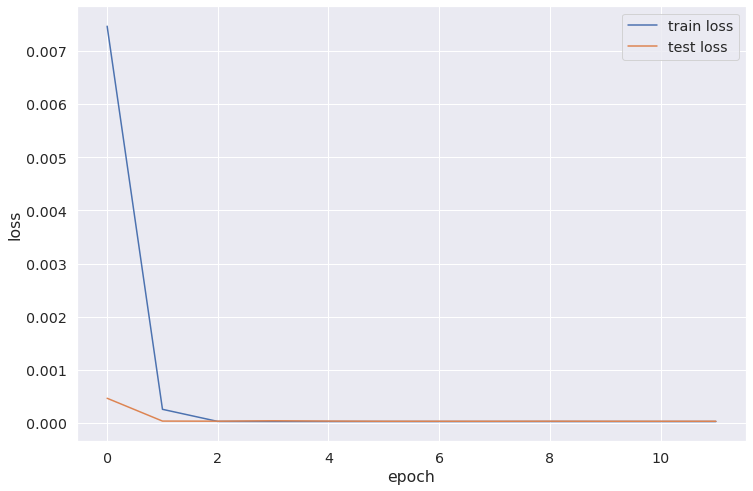

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(range(len(train_loss_hist)), train_loss_hist, label = "train loss")
plt.plot(range(len(train_loss_hist)), test_loss_hist, label = "test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/Fac/Mémoire/ae_dict.pt")
torch.save(train_loss_hist, "/content/drive/My Drive/Fac/Mémoire/ae_train_loss.pt")
torch.save(test_loss_hist, "/content/drive/My Drive/Fac/Mémoire/ae_test_loss.pt")

In [ ]:
fraude_dataloader = DataLoader(dataset_fraude, batch_size = 1, shuffle = False, num_workers = 0)
non_fraude_dataloader = DataLoader(non_fraude_test, batch_size = 1, shuffle = False, num_workers = 0)

In [ ]:
print(len(fraude_dataloader))
print(len(non_fraude_dataloader))

8213
63545


In [ ]:
y1_true = np.ones(len(fraude_dataloader), dtype = int)
y2_true = np.zeros(len(non_fraude_dataloader), dtype = int)

y_true = np.concatenate([y1_true, y2_true])
y_true

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
y1_pred = []
y2_pred = []

with torch.no_grad():

  # y1_pred : fraude
  for i, inputs in enumerate(fraude_dataloader, 0):
    print(f"\rfraude : {i/len(fraude_dataloader):.0%}", end = "")
    outputs = model.forward(inputs)
    loss = criterion(outputs, inputs).item()
    y1_pred.append(loss)

  print()

  # y2_pred : non-fraude
  for i, inputs in enumerate(non_fraude_dataloader, 0):
    print(f"\rnon-fraude : {i/len(non_fraude_dataloader):.0%}", end = "")
    outputs = model.forward(inputs)
    loss = (criterion(outputs, inputs).item())
    y2_pred.append(loss)

  print()

y_pred_raw = np.concatenate([y1_pred, y2_pred])

fraude : 100%
non-fraude : 100%


In [ ]:
start = 10e-8
stop = 10e-6
step = 10e-9
len(np.arange(start, stop, step))

990

100%

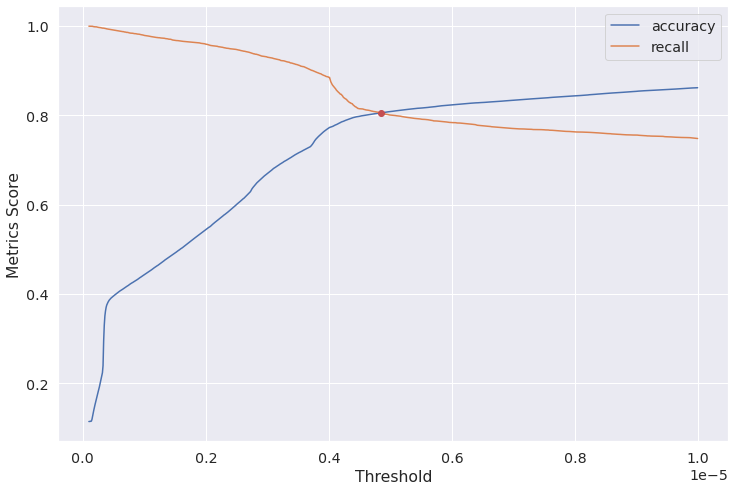

In [ ]:
start = 10e-8
stop = 10e-6
step = 10e-9

threshold_hist = []
accuracy_hist = []
recall_hist = []

k = 0

for i in np.arange(start, stop, step):

  # Progression 
  print(f"\r{k/len(np.arange(start, stop, step)):.0%}", end = "")
  k += 1

  # Fixing the threshold
  threshold = i
  y_pred = np.where(y_pred_raw > threshold, 1, 0)
  threshold_hist.append(threshold)

  # Confusion matrix
  conf_mat = confusion_matrix(y_true, y_pred)

  # True negative
  TP = conf_mat[0][0]

  # True positive
  TN = conf_mat[1][1]

  # False positive
  FP = conf_mat[0][1]

  # False negative
  FN = conf_mat[1][0]

  # Metrics
  accuracy = (TP + TN)/len(y_true)
  recall = TN / (TN + FN)

  accuracy_hist.append(accuracy)
  recall_hist.append(recall)

index = int(np.argwhere(np.diff(np.sign(np.asarray(accuracy_hist) - np.asarray(recall_hist)))))

fig = plt.figure(figsize=(12,8))
plt.plot(threshold_hist, accuracy_hist, label = "accuracy")
plt.plot(threshold_hist, recall_hist, label = "recall")
plt.plot(threshold_hist[index], recall_hist[index], 'ro')
plt.xlabel("Threshold")
plt.ylabel("Metrics Score")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
best_accuracy = accuracy_hist[index]
best_recall = recall_hist[index]
best_threshold = threshold_hist[index]
print(f"Accuracy : {best_accuracy:.2%}  --- Recall : {best_recall:.2%} --- Threshold : {best_threshold:.4}")

Accuracy : 80.61%  --- Recall : 80.62% --- Threshold : 4.84e-06


In [ ]:
# Confusion matrix
threshold = best_threshold
y_pred = np.where(y_pred_raw > threshold, 1, 0)
conf_mat = confusion_matrix(y_true, y_pred)

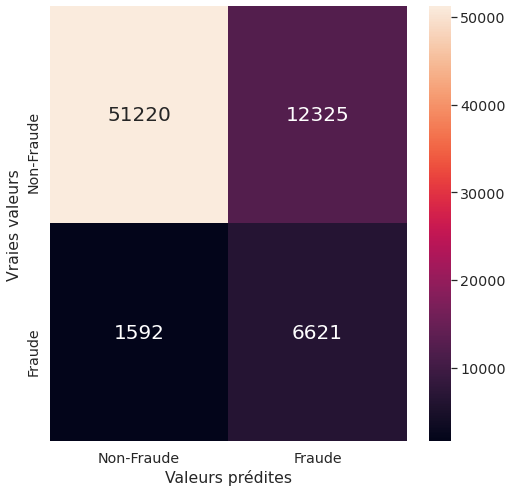

In [ ]:
# Plot the confusion matrix
fig = plt.figure(figsize = (8,8))
sns.set(font_scale = 1.3)
sns.heatmap(conf_mat, xticklabels = ["Non-Fraude","Fraude"], yticklabels = ["Non-Fraude","Fraude"], annot = True, fmt = "d", annot_kws={"size": 20})
plt.xlabel("Valeurs prédites")
plt.ylabel("Vraies valeurs")
plt.show()

In [ ]:
# True negative
TP = conf_mat[0][0]

# True positive
TN = conf_mat[1][1]

# False positive
FP = conf_mat[0][1]

# False negative
FN = conf_mat[1][0]

# Metrics
accuracy = (TP + TN)/len(y_true)
recall = TN / (TN + FN)

print(f"Threshold : {threshold} --- Accuracy : {accuracy:.2%} --- Recall : {recall:.2%}")

Threshold : 4.8399999999999986e-06 --- Accuracy : 80.61% --- Recall : 80.62%


In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_raw)

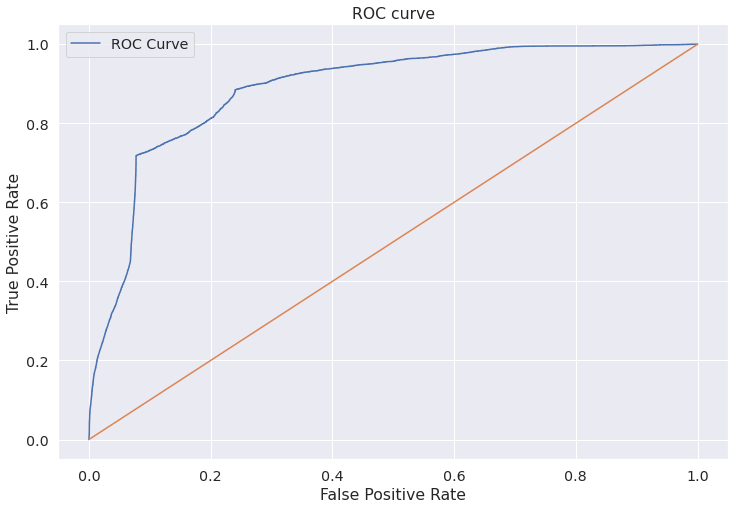

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, label = "ROC Curve")
plt.plot([tpr[0], tpr[len(tpr)-1]])
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
pr, rc, thresholds = precision_recall_curve(y_true, y_pred_raw)

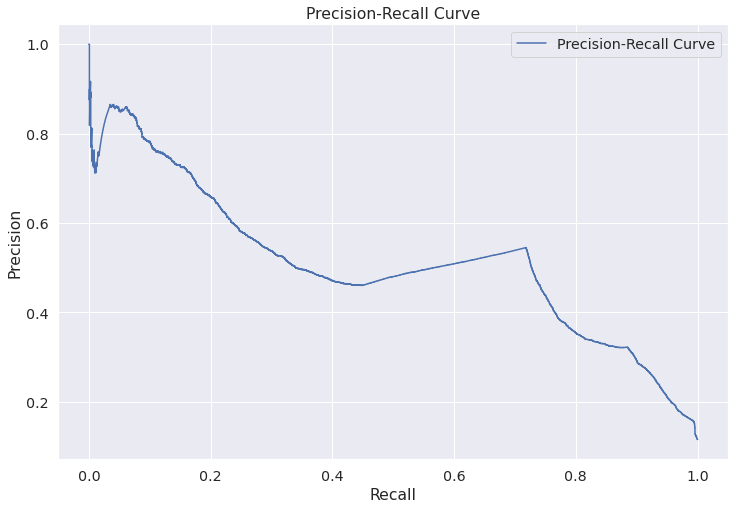

In [ ]:
fig = plt.figure(figsize=(12,8))
plt.plot(rc, pr, label = "Precision-Recall Curve")
# plt.plot([tpr[0], tpr[len(tpr)-1]])
plt.legend()
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)